In [1]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [2]:
project_name='rock-paper-scissors'

In [3]:
    
# Look into the data directory
data_dir = './datasets/complex-images'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

# data_dir = "./archive"
# print(os.listdir(data_dir))
# classes = os.listdir(data_dir + "/Rock-Paper-Scissors/train")
# print(classes)

['test', 'train', 'validation']
['paper', 'rock', 'scissors']


In [ ]:
from PIL import Image
import torchvision.transforms as transforms



# load the image
img_path = data_dir + "/train/paper/glu_174.png"
img = Image.open(img_path)
transform = transforms.Compose([
    transforms.ToTensor()
]) 
# transform the pIL image to tensor
# image
img_tr = transform(img)

img_tr = transform(img)
 
# calculate mean and std
mean, std = img_tr.mean([1,2]), img_tr.std([1,2])
 
# print mean and std
print("mean and std before normalize:")
print("Mean of the image:", mean)
print("Std of the image:", std)

transform_norm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
 
# get normalized image
img_normalized = transform_norm(img)

# Data transforms (normalization & data augmentation)


In [4]:
#Working for common images
# stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
#Working for normal white images
#stats = ((0.8763, 0.8430, 0.8365), (0.2030, 0.2536, 0.2634))

#For complex with face images
# stats = ((0.3754, 0.3303, 0.3217), (0.2652, 0.2442, 0.2305))

stats=((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
# stats=((-0.8244, -1.0126, -0.7527)), ((1.2136, 1.1163, 1.0315))


train_tfms = tt.Compose([tt.Resize((32,32)), 
                         tt.RandomHorizontalFlip(), 
                         tt.ToTensor(), 
                         tt.Normalize(*stats,inplace=True)])
valid_tfms = tt.Compose([tt.Resize((32,32)),tt.ToTensor(), tt.Normalize(*stats)])


In [5]:
# PyTorch datasets
train_ds = ImageFolder(data_dir+'/train', train_tfms)
valid_ds = ImageFolder(data_dir+'/test', valid_tfms)
test_ds = ImageFolder(data_dir+'/validation', valid_tfms)

print(type(valid_ds))

<class 'torchvision.datasets.folder.ImageFolder'>


In [6]:
batch_size = 128

In [7]:
# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)

In [ ]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break
show_batch(train_dl)

In [8]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [9]:
device = get_default_device()
device

device(type='cpu')

In [10]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [11]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [12]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out)
        out = self.classifier(out)
        return out

In [13]:
model = to_device(ResNet9(3, 3), device)

In [ ]:
from torchsummary import summary
summary(model,(3,32,32),128)

In [ ]:
from sklearn.model_selection import KFold
from torch.utils.data import ConcatDataset


k=3
splits=KFold(n_splits=k,shuffle=True,random_state=42)
dataset = ConcatDataset([train_ds, valid_ds])

In [ ]:
# @torch.no_grad()
# def evaluate(model, val_loader):
#     model.eval()
#     outputs = [model.validation_step(batch) for batch in val_loader]
#     return model.validation_epoch_end(outputs)

# def get_lr(optimizer):
#     for param_group in optimizer.param_groups:
#         return param_group['lr']

# def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
#                   weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
#     torch.cuda.empty_cache()
#     history = []
    
#     # Set up cutom optimizer with weight decay
#     optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
#     # Set up one-cycle learning rate scheduler
#     sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
#                                                 steps_per_epoch=len(train_loader))
#     dataset = ConcatDataset([train_ds, valid_ds])
#     for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(dataset)))):
#         print("Fold:-", fold)
        
#         for epoch in range(epochs):
#             # Training Phase 
#             model.train()
#             train_losses = []
#             lrs = []
#             for batch in train_loader:
#                 loss = model.training_step(batch)
#                 train_losses.append(loss)
#                 loss.backward()

#                 # Gradient clipping
#                 if grad_clip: 
#                     nn.utils.clip_grad_value_(model.parameters(), grad_clip)

#                 optimizer.step()
#                 optimizer.zero_grad()
                
#                 # Record & update learning rate
#                 lrs.append(get_lr(optimizer))
                                
# #                 sched.step()
                

#             # Validation phase
#             result = evaluate(model, val_loader)
#             result['train_loss'] = torch.stack(train_losses).mean().item()
#             result['lrs'] = lrs
#             model.epoch_end(epoch, result)
#             history.append(result)
#     return history

In [14]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [15]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 1.101110577583313, 'val_acc': 0.29296875}]

In [16]:
epochs = 8
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [17]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00372, train_loss: 1.0064, val_loss: 2.6151, val_acc: 0.3242
Epoch [1], last_lr: 0.00932, train_loss: 0.5325, val_loss: 8.8367, val_acc: 0.5599
Epoch [2], last_lr: 0.00972, train_loss: 0.4525, val_loss: 2.8280, val_acc: 0.5193
Epoch [3], last_lr: 0.00812, train_loss: 0.4439, val_loss: 1.4506, val_acc: 0.5720
Epoch [4], last_lr: 0.00556, train_loss: 0.3282, val_loss: 2.2271, val_acc: 0.5538
Epoch [5], last_lr: 0.00283, train_loss: 0.2482, val_loss: 1.0279, val_acc: 0.6324
Epoch [6], last_lr: 0.00077, train_loss: 0.1933, val_loss: 1.1456, val_acc: 0.6373
Epoch [7], last_lr: 0.00000, train_loss: 0.1702, val_loss: 1.2015, val_acc: 0.6390
Wall time: 3min 35s


In [ ]:
torch.save(model, './saved_model.pth')

In [ ]:
model = torch.load('./saved_model.pth')

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [ ]:
plot_losses(history)

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

In [ ]:
plot_lrs(history)

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_ds.classes[preds[0].item()]

In [ ]:
img, label = valid_ds[450]

mean, std = img.mean([1,2]), img.std([1,2])

print(mean,std)
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', valid_ds.classes[label], ', Predicted:', predict_image(img, model))

##### from PIL import Image

# Read a PIL image
image = Image.open('./archive2/test/paper/nasmi_166.png')
plt.imshow(image)
plt.show()  

print(image.size)

stats_test = ((0.8763, 0.8430, 0.8365), (0.2030, 0.2536, 0.2634))
test_tfms = tt.Compose([tt.Resize((32,32)),tt.ToTensor(), tt.Normalize(*stats_test)])
test_ds = ImageFolder('./archive2/test', test_tfms)
test_dl = DataLoader(test_ds, batch_size*2, num_workers=3, pin_memory=True)


In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

In [24]:
def predict_image_for_accuracy(img):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
#     print(preds[0])
    # Retrieve the class label
    return preds[0]

In [25]:
print(len(test_ds))

66


[0, 0, 0, 2, 2, 2, 2, 1, 2, 2, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 1, 2, 1, 1, 1, 1, 0, 0, 1, 2, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


<AxesSubplot:>

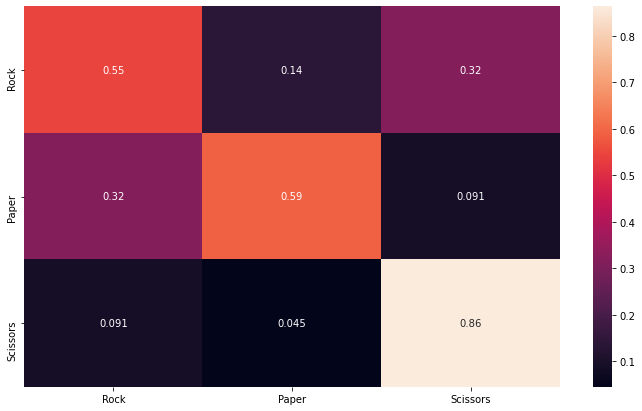

In [26]:
predicted_image_list = []

# image, label = valid_ds[10]

# print(type(image))
# a = predict_image_for_accuracy(image)
# print(a)
# print(type(a))a
# print(type(label))
# print(valid_ds.classes[a])
# print(valid_ds.classes[label])

for i in range(66):
    image, label = test_ds[i]
    
    output = predict_image_for_accuracy(image) # Feed Network
    y_pred.append(output.item()) # Save Prediction    
    y_true.append(label) # Save Truth 

print(y_pred)
print(y_true)
# constant for classes
classes = ('Rock', 'Paper', 'Scissors')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1), index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)

In [ ]:
def calculate_class_accuracy(outputs, targets, class_idx):
    """Calculates the accuracy for a specific class
    Args:
        outputs (torch.Tensor): The model outputs (logits) of shape (batch_size, num_classes)
        targets (torch.Tensor): The true labels of shape (batch_size,)
        class_idx (int): The index of the class for which accuracy is to be calculated
    Returns:
        float: The accuracy for the specific class
    """
    class_correct = (outputs.argmax(dim=1) == targets).sum().float()
    class_total = (targets == class_idx).sum().float()

    return class_correct / class_total if class_total > 0 else 0

In [ ]:
# calculate_class_accuracy(,valid_dl)

In [ ]:
paper_images = 